In [3]:
%reset
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
from matplotlib.pyplot import cm
import cmocean

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [4]:
# solves G''(z) + (N^2(z) - omega^2)G(z)/c^2 = 0 G is vertical structure of isopycnal displacement, units m.
#dG/dz = F(z) (here called Gz), vertical structure of horizontal velocity and is unitless

#   subject to G'(0) = gG(0)/c^2 (free surface) & G(-D) = 0 (flat bottom)
# G(z) is normalized so that the vertical integral of (G'(z))^2 is D
# G' is dimensionless, G has dimensions of length

# - N is buoyancy frequency [s^-1] (nX1 vector)
# - depth [m] (maximum depth is considered the sea floor) (nX1 vector)
# - omega is frequency [s^-1] (scalar)
# - mmax is the highest baroclinic mode calculated
# - m=0 is the barotropic mode
# - 0 < m <= mmax are the baroclinic modes
# - Modes are calculated by expressing in finite difference form 1) the
#  governing equation for interior depths (rows 2 through n-1) and 2) the
#  boundary conditions at the surface (1st row) and the bottome (last row).
# - Solution is found by solving the eigenvalue system A*x = lambda*B*x
def vertical_modes(N2_0, Depth, omega, mmax):
    z = -1 * Depth

    if np.size(np.shape(N2_0)) > 1:
        N2 = np.nanmean(N2_0, axis=1)
    else:
        N2 = N2_0

    n = np.size(z)
    nm1 = n - 1
    nm2 = n - 2
    gravity = 9.82
    # ----- vertical increments
    dz = np.concatenate([[0], z[1:] - z[0:nm1]])  # depth increment [m]
    dzm = np.concatenate([[0], 0.5 * (z[2:] - z[0:nm2]), [0]])  # depth increment between midpoints [m]
    # ----- sparse matrices
    # A = row pos, B = col pos, C = val  
    A = np.concatenate([[0], [0], np.arange(1, nm1), np.arange(1, nm1), np.arange(1, nm1), [n - 1]])
    B = np.concatenate([[0], [1], np.arange(1, nm1), np.arange(0, nm2), np.arange(2, n), [n - 1]])
    C = np.concatenate(
        [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
         -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
        # [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
        #  -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
    mat1 = coo_matrix((C, (A, B)), shape=(n, n))

    D = np.concatenate([[0], np.arange(1, n)])
    E = np.concatenate([[0], np.arange(1, n)])
    F = np.concatenate([[gravity], N2[1:] - omega * omega])  # originially says N2[1:,10]
    mat2 = coo_matrix((F, (D, E)), shape=(n, n))

    # compute eigenvalues and vectors 
    vals, vecs = eigs(mat1, k=mmax + 1, M=mat2, sigma=0)
    eigenvalue = np.real(vals)
    wmodes = np.real(vecs)
    s_ind = np.argsort(eigenvalue)
    eigenvalue = eigenvalue[s_ind]
    wmodes = wmodes[:, s_ind]
    m = np.size(eigenvalue)
    c = 1 / np.sqrt(eigenvalue)  # kelvin wave speed
    # normalize mode (shapes)
    Gz = np.zeros(np.shape(wmodes))
    G = np.zeros(np.shape(wmodes))
    for i in range(m):
        dw_dz = np.nan * np.ones(np.shape(z))
        dw_dz[0] = (wmodes[1, i] - wmodes[0, i]) / (z[1] - z[0])
        dw_dz[-1] = (wmodes[-1, i] - wmodes[-2, i]) / (z[-1] - z[-2])
        for j in range(1, len(z) - 1):
            dw_dz[j] = (wmodes[j + 1, i] - wmodes[j - 1, i]) / (z[j + 1] - z[j - 1])
        # dw_dz = np.gradient(wmodes[:, i], z)
        norm_constant = np.sqrt(np.trapz((dw_dz * dw_dz), (-1 * z)) / (-1 * z[-1]))
        # norm_constant = np.abs(np.trapz(dw_dz * dw_dz, z) / Depth.max())

        if dw_dz[0] < 0:
            norm_constant = -1 * norm_constant
        Gz[:, i] = dw_dz / norm_constant

        norm_constant_G = np.sqrt(np.trapz((wmodes[:, i] * wmodes[:, i]), (-1 * z)) / (-1 * z[-1]))
        G[:, i] = wmodes[:, i] / norm_constant

    #epsilon = np.nan * np.zeros((5, 5, 5))  # barotropic and first 5 baroclinic
    #for i in range(0, 5):  # i modes
    #    for j in range(0, 5):  # j modes
    #        for m in range(0, 5):  # k modes
    #            epsilon[i, j, m] = np.trapz((Gz[:, i] * Gz[:, j] * Gz[:, m]), -1.0*z) / (-1.0*z[-1])

    return G, Gz, c#, epsilon
#G is the displacement modes and Gz is velocity modes (Gz = dG/dz = F)

## Computing QG modes at an individual gridbox. 
### Reading in various parameterized runs -- they are all at 1/2 degree resolution.

In [63]:
#/neerajab/NeverWorld2/runGM/run1 has KHTH=100
#/neerajab/NeverWorld2/runGM/run3 has KHTH=500
#/neerajab/NeverWorld2/runGM/run6 has KHTH=2500
#/neerajab/NeverWorld2/runGM/run7 has KHTH=5000

#TUNED VERSIONS:
#/gmarques/NeverWorld2/Visbeck/nw2_0.5deg_N15_Visbeck_run3      TUNED! has Visbeck scheme on
#/gmarques/NeverWorld2/GEOMETRIC/nw2_0.5deg_N15_GEOMETRIC_run3  TUNED! has Geometric scheme (Marshall et al. 2012)
#/gmarques/NeverWorld2/TMEKE/nw2_0.5deg_N15_TMEKE_run3          TUNED! has MEKE+GM from Jansen et al. (topographic beta in rhines scale=topographic MEKE)

#not working or untuned:
#/gmarques/NeverWorld2/DM07/nw2_0.5deg_N15_DM07_run2           !NOT TUNED has Danabasoglu & Marshall 2007 stratification based scheme on
#/gmarques/NeverWorld2/nw2_0.5deg_N15_MEKE_OM4                 has OM4_p5 settings except FGNV is off...
#/gmarques/NeverWorld2/nw2_0.5deg_N15_QG_Leith  has QG Leith scheme on but not working?


%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/TMEKE/nw2_0.5deg_N15_TMEKE_run3 
%ls
fs=xr.open_dataset('static.nc', decode_times=False)
os=xr.open_dataset('ocean.stats.nc', decode_times=False)
#av=xr.open_dataset('averages_00028502.nc',decode_times=False)
av=xr.open_dataset('averages_00031002.nc',decode_times=False)

%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/

/glade/scratch/gmarques/NW2_TMP/nw2_0.5deg_N15_TMEKE_run3
available_diags.000000  longmean_00010250.nc         MOM_parameter_doc.layout
averages_00030002.nc    longmean_00012250.nc         MOM_parameter_doc.short
averages_00030502.nc    longmean_00014250.nc         ocean_geometry.nc
averages_00031002.nc    longmean_00015250.nc         ocean.stats
averages_00031502.nc    longmean_00016250.nc         ocean.stats.nc
CPU_stats               longmean_00018250.nc         README
diag_table@             longmean_00020250.nc         RESTART/
diag_table.final        longmean_00022250.nc         snapshots_00030005.nc
diag_table.init         longmean_00024250.nc         snapshots_00030505.nc
exitcode                longmean_00026250.nc         snapshots_00031005.nc
INPUT/                  longmean_00028250.nc         snapshots_00031505.nc
input.nml               longmean_00030250.nc         static.nc
logfile.000000.out      MOM_IC.nc                    submit_cheyenne
longmean_00000250.nc    MOM_i

### Reading in 1/32 deg. truth case

In [36]:
%cd /glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_baseline/
fs = xr.open_dataset('static.nc', decode_times=False)
os = xr.open_dataset('ocean.stats.nc', decode_times=False)
av = xr.open_dataset('averages_00001202.nc', decode_times=False)
%cd /glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis/


/glade/p/univ/unyu0004/gmarques/NeverWorld2/nw2_0.03125deg_N15_baseline
/glade/p/univ/unyu0004/eyankovsky/NeverWorld_analysis


In [64]:
lon=fs['geolon']; lat=fs['geolat']
depth = fs['depth_ocean']
Coriolis = fs['Coriolis'].values

xh = fs.xh.values
yh = fs.yh.values

In [65]:
#1/2 degree:280 lat x 120 lon 
index_lon=30; index_lat=230 #1/4 degree: NW(30,230), ACC(30,40)

f_local = np.abs(Coriolis[index_lat+1,index_lon+1])
print(f_local)

0.00010402187


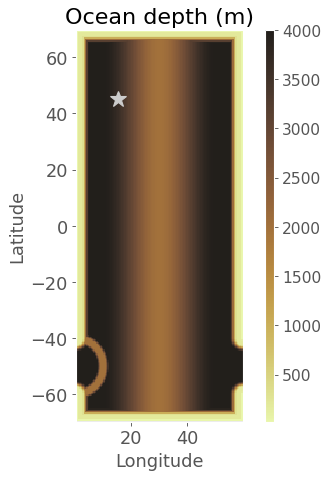

In [66]:
#Plotting ocean depth
fig = plt.figure(figsize=(4, 7), dpi= 80, facecolor='w', edgecolor='k')
ax1 = fig.add_axes([0.15,0.2,0.6,0.7]) 
ax2 = fig.add_axes([.78, 0.2, 0.03, 0.7])
ax1.set_facecolor((0.92, 0.92, 0.92))
ax1.set_title('Ocean depth (m)',fontsize=20)
ax1.set_xlabel('Longitude',fontsize=16)
ax1.set_ylabel('Latitude',fontsize=16)
ax1.tick_params(labelsize=16); 
ax2.tick_params(labelsize=14)

plotted =ax1.pcolor(xh,yh,depth,cmap=cmocean.cm.turbid)
ax1.plot(xh[index_lon],yh[index_lat],'*',markersize=15,color=[0.8, 0.8, 0.8])
ax1.set_aspect('equal', 'box')
cbar = plt.colorbar(mappable=plotted, cax=ax2, orientation = 'vertical');
cbar.ax.tick_params(labelsize=14);
#
plt.show()
#fig.savefig('topography.png')

In [67]:
tlength = 100

Layer = np.array(os['Layer']);
Layermat=np.tile(Layer,[len(xh),1]);   Layermat=np.moveaxis(Layermat, [0, 1], [1, 0])
Interface = np.array(os['Interface']); drho=np.diff(Interface)
eta = np.zeros([tlength,len(Layer)+1]);

BT_KE=np.zeros(tlength)
BC_KE=np.zeros(tlength)
KE_u_t=np.zeros([tlength,15])
KE_v_t=np.zeros([tlength,15])
BC_PE=np.zeros(tlength)
PE_t=np.zeros([tlength,15])
wavenumbers = np.zeros(15)



v = np.nanmean(np.array(av['v'][:,:,index_lat-1:index_lat+1,index_lon]),axis=2);
u = np.nanmean(np.array(av['u'][:,:,index_lat,index_lon-1:index_lon+1]),axis=2); 
v=np.column_stack([v, 0.0*v[:,-1]]); u=np.column_stack([u, 0.0*u[:,-1]]) #add bottom BC point where u,v,=0

h = np.array(av['h'][:,:,index_lat,index_lon]);


for i in range(1,len(Layer)+1):
    for j in range(0,tlength):
        eta[j,i]=np.nansum(h[j,0:i])  
    print(i)
    
eta[:,:-1]=(eta[:,1:]+eta[:,:-1])/2. #add bottom BC point at topography where u,v=0

drhodz=drho/h
N2=(9.81/1022.6)*drhodz
N2=np.column_stack([N2, N2[:,-1]*0.+1.e-7]) #add bottom BC point at topography where u,v=0, make the N2 small so it doesn't get filtered



eta_mean = np.nanmean(eta,axis=0); N2_mean = np.nanmean(N2,axis=0)
eta_prime= eta-eta_mean

N2_mean[N2_mean>.1] =np.nan
eta_filtered = eta_mean[~np.isnan(N2_mean)]
N2_filtered  = N2_mean[~np.isnan(N2_mean)]

    
    
nmodes = len(N2_filtered)-3
#Limit the number of modes to be 7 or 10 if it's larger than that (otherwise keep number of modes)
if ( nmodes >= 7 ):
    nmodes = 7
    
[G, Gz, c]=vertical_modes(N2_filtered, eta_filtered, 0, nmodes) #nmodes is number of BC modes, doens't include BT mode
wavenumbers[0:nmodes+1]=(1/c)*f_local
    
for i in range(0,tlength):
    ui=u[i,~np.isnan(N2_mean)]; vi=v[i,~np.isnan(N2_mean)];
    eta_prime_i=eta_prime[i,~np.isnan(N2_mean)];
    
    
    amp_u=np.linalg.lstsq(Gz,ui)[0]
    amp_v=np.linalg.lstsq(Gz,vi)[0]  #solving for alpha, units of m/s
    amp_eta=np.linalg.lstsq(G,eta_prime_i)[0] #solving for Beta, unitless

    BT_KE[i]=0.5*amp_u[0]**2+0.5*amp_v[0]**2
    BC_KE[i]=np.nansum(0.5*amp_u[1:]**2)+np.nansum(0.5*amp_v[1:]**2)
    BC_PE[i]=np.nansum(0.5*(amp_eta[1:]**2)*(c[1:]**2)) 
    
    KE_u_t[i,0:nmodes+1]=0.5*amp_u[:]**2 #has modes 
    KE_v_t[i,0:nmodes+1]=0.5*amp_v[:]**2
    PE_t[i,1:nmodes+1]=(0.5*amp_eta[1:]**2)*c[1:]**2 
    
print('done')


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
done


Text(0, 0.5, 'KE')

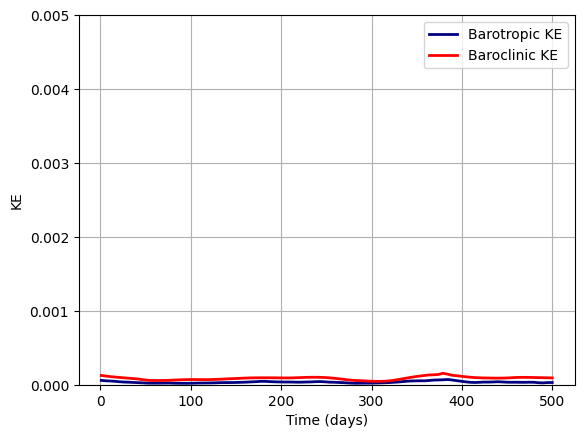

In [68]:
plt.style.use('default')
plt.plot(np.linspace(1,tlength*5,tlength),BT_KE,c=[0., 0., 0.5],linewidth=2,markersize=10)
plt.plot(np.linspace(1,tlength*5,tlength),BC_KE,c=[1, 0, 0],linewidth=2,markersize=10)

plt.grid()
plt.ylim(0,0.005);
plt.xlabel('Time (days)')
plt.legend(['Barotropic KE','Baroclinic KE'])
plt.ylabel('KE')

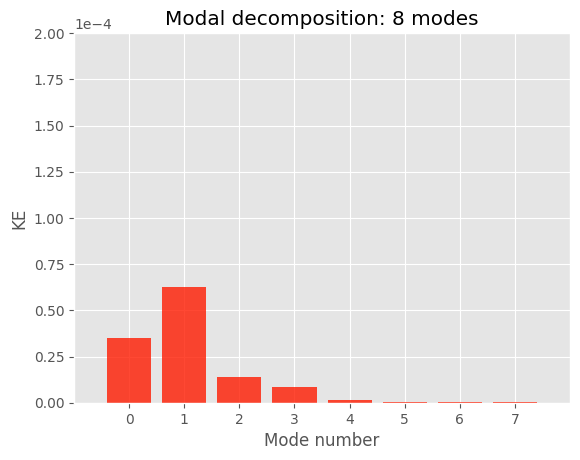

In [69]:
plt.style.use('ggplot')
x = np.linspace(0,14,15)
amp1 = np.nanmean(KE_u_t+KE_v_t,axis=0)

plt.bar(x, amp1, color=[1., .1, 0.],alpha=0.8)
plt.xlabel("Mode number")
plt.ylabel("KE")
plt.title("Modal decomposition: %i modes" % (nmodes+1))
#plt.ylim(0,3e-2)
plt.ylim(0,2e-4)
plt.xlim(-1,8)
plt.xticks((0,1,2,3,4,5,6,7))
plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))

In [52]:
xKE_GM100 = np.linspace(0,14,15); 
xKE_GM100[0]=.9
ampKE_GM100 = np.nanmean(KE_u_t+KE_v_t,axis=0)
wavenumbers_GM100=wavenumbers

xPE_GM100 = np.linspace(1,14,14)
ampPE_GM100 = np.nanmean(PE_t[:,1:],axis=0) #remove BT mode from PE

nmodes_GM100 = nmodes
print('done')

done


In [60]:
xKE_GM500 = np.linspace(0,14,15); 
xKE_GM500[0]=.9
ampKE_GM500 = np.nanmean(KE_u_t+KE_v_t,axis=0)
wavenumbers_GM500=wavenumbers

xPE_GM500 = np.linspace(1,14,14)
ampPE_GM500 = np.nanmean(PE_t[:,1:],axis=0) #remove BT mode from PE

nmodes_GM500 = nmodes
print('done')

done


In [67]:
xKE_GM2500 = np.linspace(0,14,15); 
xKE_GM2500[0]=.9
ampKE_GM2500 = np.nanmean(KE_u_t+KE_v_t,axis=0)
wavenumbers_GM2500=wavenumbers

xPE_GM2500 = np.linspace(1,14,14)
ampPE_GM2500 = np.nanmean(PE_t[:,1:],axis=0) #remove BT mode from PE

nmodes_GM2500 = nmodes
print('done')

done


In [74]:
xKE_GM5000 = np.linspace(0,14,15); 
xKE_GM5000[0]=.9
ampKE_GM5000 = np.nanmean(KE_u_t+KE_v_t,axis=0)
wavenumbers_GM5000=wavenumbers

xPE_GM5000 = np.linspace(1,14,14)
ampPE_GM5000 = np.nanmean(PE_t[:,1:],axis=0) #remove BT mode from PE

nmodes_GM5000 = nmodes
print('done')

done


In [17]:
xKE_Visbeck = np.linspace(0,14,15); 
xKE_Visbeck[0]=.9
ampKE_Visbeck = np.nanmean(KE_u_t+KE_v_t,axis=0)
wavenumbers_Visbeck=wavenumbers

xPE_Visbeck = np.linspace(1,14,14)
ampPE_Visbeck = np.nanmean(PE_t[:,1:],axis=0) #remove BT mode from PE

print('done')

done


In [32]:
xKE_TMEKE = np.linspace(0,14,15); 
xKE_TMEKE[0]=.9
ampKE_TMEKE = np.nanmean(KE_u_t+KE_v_t,axis=0)
wavenumbers_TMEKE=wavenumbers

xPE_TMEKE = np.linspace(1,14,14)
ampPE_TMEKE = np.nanmean(PE_t[:,1:],axis=0) #remove BT mode from PE

print('done')

done


In [24]:
xKE_GEOM = np.linspace(0,14,15); 
xKE_GEOM[0]=.9
ampKE_GEOM = np.nanmean(KE_u_t+KE_v_t,axis=0)
wavenumbers_GEOM=wavenumbers

xPE_GEOM = np.linspace(1,14,14)
ampPE_GEOM = np.nanmean(PE_t[:,1:],axis=0) #remove BT mode from PE

print('done')

done


In [42]:
xKE_truth = np.linspace(0,14,15); 
xKE_truth[0]=.9
ampKE_truth = np.nanmean(KE_u_t+KE_v_t,axis=0)
wavenumbers_truth=wavenumbers

xPE_truth = np.linspace(1,14,14)
ampPE_truth = np.nanmean(PE_t[:,1:],axis=0) #remove BT mode from PE

print('done')

done


In [238]:
nmodes

7

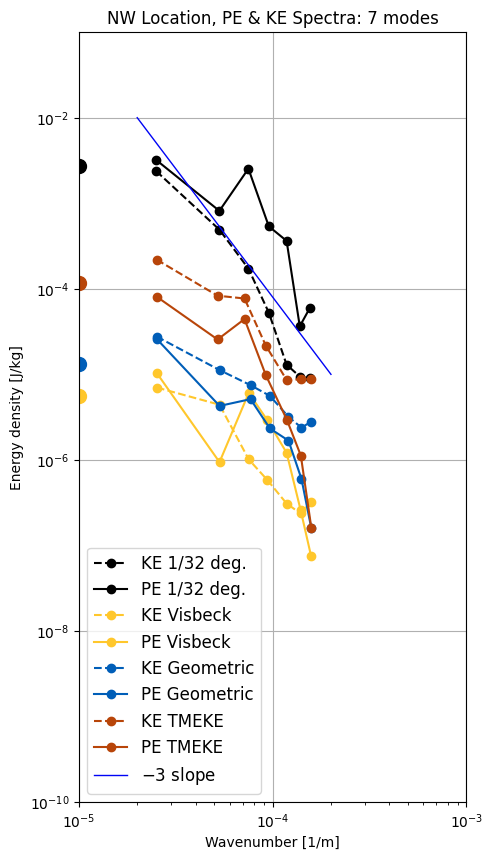

In [43]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(5,10), dpi= 100)
#plt.style.use('ggplot')


plt.loglog(abs(wavenumbers_truth[1:nmodes+1]), (ampKE_truth[1:nmodes+1]), '--o',color='k')
plt.loglog(abs(wavenumbers_truth[1:nmodes+1]), (ampPE_truth[0:nmodes]),'-o',color='k')

plt.loglog(abs(wavenumbers_Visbeck[1:nmodes+1]), (ampKE_Visbeck[1:nmodes+1]), '--o',color='#FFC72C')
plt.loglog(abs(wavenumbers_Visbeck[1:nmodes+1]), (ampPE_Visbeck[0:nmodes]),'-o',color='#FFC72C')
plt.loglog(abs(wavenumbers_GEOM[1:nmodes+1]), (ampKE_GEOM[1:nmodes+1]), '--o',color='#005EB8')
plt.loglog(abs(wavenumbers_GEOM[1:nmodes+1]), (ampPE_GEOM[0:nmodes]),'-o',color='#005EB8')
plt.loglog(abs(wavenumbers_TMEKE[1:nmodes+1]), (ampKE_TMEKE[1:nmodes+1]), '--o',color='#B84509')
plt.loglog(abs(wavenumbers_TMEKE[1:nmodes+1]), (ampPE_TMEKE[0:nmodes]),'-o',color='#B84509')



plt.plot([2e-5, 2e-4],[1e-2,1e-5],color='#0004f5',linewidth=1)

plt.loglog(1.e-5, ampKE_truth[0], 'o',color='k',Markersize=10)
plt.loglog(1.e-5, ampKE_Visbeck[0], 'o',color='#FFC72C',Markersize=10)
plt.loglog(1.e-5, ampKE_GEOM[0], 'o',color='#005EB8',Markersize=10)
plt.loglog(1.e-5, ampKE_TMEKE[0], 'o',color='#B84509',Markersize=10)




plt.xlabel("Wavenumber [1/m]")
plt.ylabel("Energy density [J/kg]")
plt.title("NW Location, PE & KE Spectra: %i modes" % (nmodes))
plt.xlim(1e-5,1e-3) #2e-5 to 2e-4 before
plt.ylim(1e-10,1e-1)

ax = plt.gca()
plt.tick_params(axis='x', which='minor')
#ax.xaxis.set_ticklabels([r'$2\times10^{-4}$','','',r'$5\times10^{-4$}','','','','', 
#        r'$2\times 10^{-5}$','','',r'$5\times10^{-5}$','','','','',
#        r'$2\times 10^{-4}$'],minor=True,fontsize=8)



plt.legend(['KE 1/32 deg.','PE 1/32 deg.','KE Visbeck','PE Visbeck','KE Geometric','PE Geometric','KE TMEKE','PE TMEKE','$-3$ slope'],fontsize=12)
plt.grid()
#ax.set_aspect('equal')

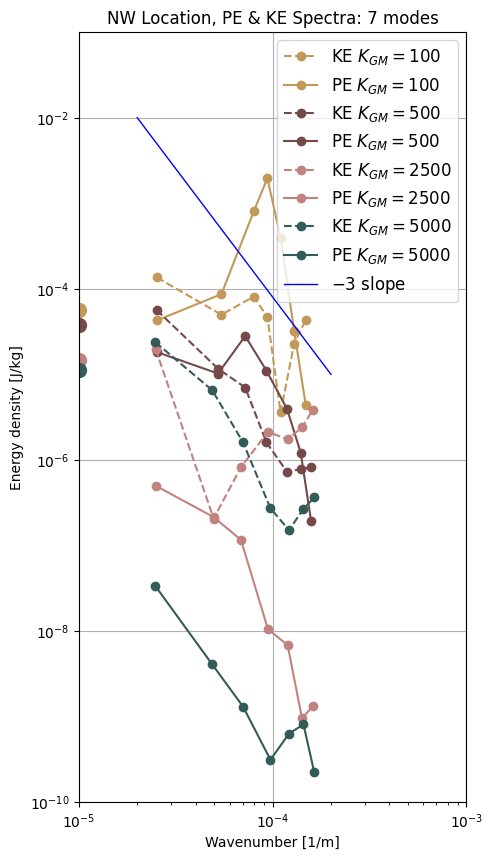

In [78]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(5,10), dpi= 100)
#plt.style.use('ggplot')

plt.loglog(abs(wavenumbers_GM100[1:nmodes_GM100+1]), (ampKE_GM100[1:nmodes_GM100+1]), '--o',color='#C29959')
plt.loglog(abs(wavenumbers_GM100[1:nmodes_GM100+1]), (ampPE_GM100[0:nmodes_GM100]),'-o',color='#C29959')

plt.loglog(abs(wavenumbers_GM500[1:nmodes_GM500+1]), (ampKE_GM500[1:nmodes_GM500+1]), '--o',color='#754948')
plt.loglog(abs(wavenumbers_GM500[1:nmodes_GM500+1]), (ampPE_GM500[0:nmodes_GM500]),'-o',color='#754948')

plt.loglog(abs(wavenumbers_GM2500[1:nmodes_GM2500+1]), (ampKE_GM2500[1:nmodes_GM2500+1]), '--o',color='#C28280')
plt.loglog(abs(wavenumbers_GM2500[1:nmodes_GM2500+1]), (ampPE_GM2500[0:nmodes_GM2500]),'-o',color='#C28280')

plt.loglog(abs(wavenumbers_GM5000[1:nmodes_GM5000+1]), (ampKE_GM5000[1:nmodes_GM5000+1]), '--o',color='#335C58')
plt.loglog(abs(wavenumbers_GM5000[1:nmodes_GM5000+1]), (ampPE_GM5000[0:nmodes_GM5000]),'-o',color='#335C58')


plt.plot([2e-5, 2e-4],[1e-2,1e-5],color='#0004f5',linewidth=1)

plt.loglog(1.e-5, ampKE_GM100[0], 'o',color='#C29959',Markersize=10)
plt.loglog(1.e-5, ampKE_GM500[0], 'o',color='#754948',Markersize=10)
plt.loglog(1.e-5, ampKE_GM2500[0], 'o',color='#C28280',Markersize=10)
plt.loglog(1.e-5, ampKE_GM5000[0], 'o',color='#335C58',Markersize=10)


plt.xlabel("Wavenumber [1/m]")
plt.ylabel("Energy density [J/kg]")
plt.title("NW Location, PE & KE Spectra: %i modes" % (nmodes_GM100))
plt.xlim(1e-5,1e-3) #2e-5 to 2e-4 before
plt.ylim(1e-10,1e-1)

ax = plt.gca()
plt.tick_params(axis='x', which='minor')
#ax.xaxis.set_ticklabels([r'$2\times10^{-4}$','','',r'$5\times10^{-4$}','','','','', 
#        r'$2\times 10^{-5}$','','',r'$5\times10^{-5}$','','','','',
#        r'$2\times 10^{-4}$'],minor=True,fontsize=8)



plt.legend(['KE $K_{GM}=100$','PE $K_{GM}=100$','KE $K_{GM}=500$','PE $K_{GM}=500$','KE $K_{GM}=2500$','PE $K_{GM}=2500$','KE $K_{GM}=5000$','PE $K_{GM}=5000$','$-3$ slope'],fontsize=12)
plt.grid()
#ax.set_aspect('equal')

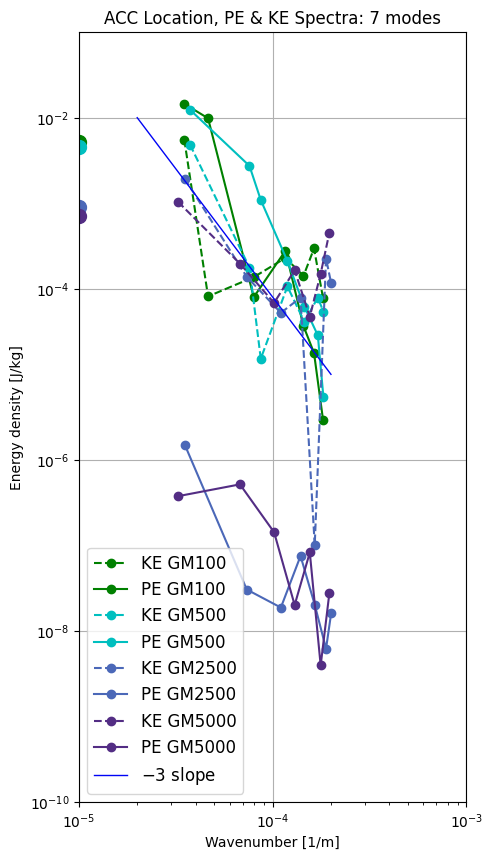

In [154]:
from matplotlib.ticker import FormatStrFormatter
plt.figure(figsize=(5,10), dpi= 100)
#plt.style.use('ggplot')

plt.loglog(abs(wavenumbers_GM100[1:nmodes_GM100+1]), (ampKE_GM100[1:nmodes_GM100+1]), '--o',color='g')
plt.loglog(abs(wavenumbers_GM100[1:nmodes_GM100+1]), (ampPE_GM100[0:nmodes_GM100]),'-o',color='g')

plt.loglog(abs(wavenumbers_GM500[1:nmodes_GM500+1]), (ampKE_GM500[1:nmodes_GM500+1]), '--o',color='c')
plt.loglog(abs(wavenumbers_GM500[1:nmodes_GM500+1]), (ampPE_GM500[0:nmodes_GM500]),'-o',color='c')

plt.loglog(abs(wavenumbers_GM2500[1:nmodes_GM2500+1]), (ampKE_GM2500[1:nmodes_GM2500+1]), '--o',color='#4B68B8')
plt.loglog(abs(wavenumbers_GM2500[1:nmodes_GM2500+1]), (ampPE_GM2500[0:nmodes_GM2500]),'-o',color='#4B68B8')

plt.loglog(abs(wavenumbers_GM5000[1:nmodes_GM5000+1]), (ampKE_GM5000[1:nmodes_GM5000+1]), '--o',color='#532D84')
plt.loglog(abs(wavenumbers_GM5000[1:nmodes_GM5000+1]), (ampPE_GM5000[0:nmodes_GM5000]),'-o',color='#532D84')


plt.plot([2e-5, 2e-4],[1e-2,1e-5],color='#0004f5',linewidth=1)

plt.loglog(1.e-5, ampKE_GM100[0], 'o',color='g',Markersize=10)
plt.loglog(1.e-5, ampKE_GM500[0], 'o',color='c',Markersize=10)
plt.loglog(1.e-5, ampKE_GM2500[0], 'o',color='#4B68B8',Markersize=10)
plt.loglog(1.e-5, ampKE_GM5000[0], 'o',color='#532D84',Markersize=10)


plt.xlabel("Wavenumber [1/m]")
plt.ylabel("Energy density [J/kg]")
plt.title("ACC Location, PE & KE Spectra: %i modes" % (nmodes_GM100))
plt.xlim(1e-5,1e-3) #2e-5 to 2e-4 before
plt.ylim(1e-10,1e-1)

ax = plt.gca()
plt.tick_params(axis='x', which='minor')
#ax.xaxis.set_ticklabels([r'$2\times10^{-4}$','','',r'$5\times10^{-4$}','','','','', 
#        r'$2\times 10^{-5}$','','',r'$5\times10^{-5}$','','','','',
#        r'$2\times 10^{-4}$'],minor=True,fontsize=8)



plt.legend(['KE GM100','PE GM100','KE GM500','PE GM500','KE GM2500','PE GM2500','KE GM5000','PE GM5000','$-3$ slope'],fontsize=12)
plt.grid()
#ax.set_aspect('equal')